---
title: "SWD Properties"
---

In [69]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [78]:
#| hide
import polars as pl
import polars.selectors as cs

from ids_finder.utils.basic import load_catalog

In [79]:
catalog = load_catalog()

Connect `python` with `R` kernel

In [53]:
%load_ext rpy2.ipython
from beforerr.r import py2rpy_polars
import rpy2.robjects as robjects
r = robjects.r
r.source('utils.R')

conv_pl = py2rpy_polars()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython

 Found  1  deps for  0/1  pkgs [⠋] Resolving standard (CRAN/BioC) packages
 
ℹ No downloads are needed

Installing...
✔ 1 pkg + 77 deps: kept 63 s]


## Processing datasets

In [54]:
all_events_l1 : pl.DataFrame = catalog.load('events.l1.ALL_sw_ts_1s_tau_60s').collect()
JUNO_events_l1 : pl.LazyFrame = catalog.load('events.l1.JNO_ts_1s_tau_60s').collect()

%R -i all_events_l1 -c conv_pl

[11/22/23 17:55:03] INFO     Loading data from 'events.l1.ALL_sw_ts_1s_tau_60s'                 ]8;id=390875;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=131839;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'events.l1.JNO_ts_1s_tau_60s'                    ]8;id=523618;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=524865;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

Some extreme values are present in the data. We will remove them.

In [55]:
NVARS = ['d_star', 'L_mn', 'L_mn_norm', 'j0', 'j0_norm', 'duration', 'v_mn']
DISPLAY_VARS = ['time', 'sat'] + NVARS


def check_candidates(df):
    if isinstance(df, pl.LazyFrame):
        df = df.collect()
    return df.select(NVARS).describe()

check_candidates(all_events_l1)

describe,d_star,L_mn,L_mn_norm,j0,j0_norm,duration,v_mn
str,f64,f64,f64,f64,f64,str,f64
"""count""",280659.0,280659.0,280659.0,280659.0,280659.0,"""280659""",280659.0
"""null_count""",0.0,0.0,524.0,0.0,524.0,"""0""",0.0
"""mean""",0.920152,2367.477254,20.580618,2.584986,0.079948,"""0:00:07.199127…",329.553267
"""std""",0.917642,1595.276579,15.017233,3.961296,0.105631,null,107.563438
"""min""",0.025615,40.087321,0.227812,0.048355,0.001512,"""0:00:01.999999…",10.02183
"""25%""",0.320934,1347.667991,11.00215,0.820725,0.030136,"""0:00:04""",267.731532
"""50%""",0.643759,1946.478797,16.805261,1.640835,0.05437,"""0:00:06""",332.005613
"""75%""",1.200805,2915.981753,25.689117,3.094273,0.095972,"""0:00:09""",393.679024
"""max""",17.98526,23486.217211,358.25329,309.826988,9.634978,"""0:00:56""",864.808497


In [56]:
jno_candidates_l1 = all_events_l1.filter(pl.col('sat') == 'JNO')
%R -i jno_candidates_l1 -c conv_pl

In [57]:
from ids_finder.pipelines.project.pipeline import process_events_l2

In [58]:
all_events_l2 = all_events_l1.pipe(process_events_l2)

In [59]:
inspect_df = all_events_l2[NVARS]
inspect_df.describe()

describe,d_star,L_mn,L_mn_norm,j0,j0_norm,duration,v_mn
str,f64,f64,f64,f64,f64,str,f64
"""count""",230.0,230.0,230.0,230.0,230.0,"""230""",230.0
"""null_count""",19.0,19.0,19.0,19.0,19.0,"""19""",19.0
"""mean""",0.877715,2531.768671,20.404879,2.524351,0.092139,"""0:00:07.665843…",330.592694
"""std""",0.403314,511.380989,5.956691,1.246774,0.04231,null,37.200308
"""min""",0.110302,1817.802966,6.878194,0.233657,0.048246,"""0:00:06.390404…",255.313629
"""25%""",0.726833,2184.782668,18.368551,1.988046,0.069698,"""0:00:06.831121…",304.836154
"""50%""",0.941395,2398.748205,21.023224,2.779766,0.078657,"""0:00:07.200184…",329.456522
"""75%""",1.129473,2750.569727,24.169994,3.241188,0.092834,"""0:00:08.172248…",354.941166
"""max""",1.775508,4231.415645,37.964232,5.746615,0.298382,"""0:00:11.537142…",444.353823


In [66]:
%R -i all_events_l2 -c conv_pl

## Plotting function

Plotting function for Level 1 data.

Similar to the `geom_bin2d` function, but with added functionality

- Normalize the data to every x-axis value
- Add peak values
- Add mean values with error bars

In [60]:
%%R
library(scales)
# Helper function to calculate summary statistics for x-binned data
calculate_summary <- function(data, x_col, y_col, x_seq) {
  data %>%
    mutate(!!x_col := x_seq[findInterval(data[[x_col]], x_seq, rightmost.closed = TRUE)]) %>%
    group_by(.data[[x_col]]) %>%
    summarise(
      mean_y = mean(.data[[y_col]], na.rm = TRUE),
      sd_y = sd(.data[[y_col]], na.rm = TRUE),
      se_y = sd_y / sqrt(n())
    )
}


plot_binned_data <- function(data, x_col, y_col, x_bins, y_bins, y_lim=NULL, log_y=FALSE) {
  
  # If y_lim is provided, filter the data
  if (!is.null(y_lim)) {
    data <- data %>%
      filter(!!sym(y_col) >= y_lim[1], !!sym(y_col) <= y_lim[2])
  }
  
  # If transform_log_y is TRUE, transform y_col to log scale
  if (log_y) {
    data[[y_col]] <- log10(data[[y_col]])
    y_label <- paste("Log10", y_col)
  } else {
    y_label <- y_col
  }
  
  # Define bins for x and y based on the input parameters
  x_seq <- seq(min(data[[x_col]]), max(data[[x_col]]), length.out = x_bins + 1)
  y_seq <- seq(min(data[[y_col]]), max(data[[y_col]]), length.out = y_bins + 1)
  
  data_binned_normalized <- data %>%
    mutate(
      !!x_col := x_seq[findInterval(data[[x_col]], x_seq, rightmost.closed = TRUE,)],
      !!y_col := y_seq[findInterval(data[[y_col]], y_seq, rightmost.closed = TRUE,)]
    ) %>%
    count(!!sym(x_col), !!sym(y_col)) %>%
    group_by(!!sym(x_col)) %>%
    mutate(n = n/sum(n))

  plot <- ggplot() +
    geom_tile(data = data_binned_normalized, aes(x = .data[[x_col]], y = .data[[y_col]], fill = n))

  # Calculate mode for each x-bin
  modes <- data_binned_normalized %>%
    group_by(.data[[x_col]]) %>%
    slice_max(n, n = 1)
    
 # Add the mode line
  plot <- plot + geom_line(data = modes, aes(x = .data[[x_col]], y = .data[[y_col]], group = 1), linetype = "dashed")

  data_xbinned <- calculate_summary(data, x_col, y_col, x_seq)
  
  plot <- plot +
    geom_errorbar(data = data_xbinned, aes(x = .data[[x_col]], ymin = mean_y - sd_y, ymax = mean_y + sd_y), width = 0.2) +
    geom_line(data = data_xbinned, aes(x = .data[[x_col]], y = mean_y))
    # Note: ggline will produce another figure, so we use geom_line instead


  plot <- plot + labs(y = y_label) + # Set y-axis label
    scale_fill_viridis_c() +
    theme_pubr(base_size = 16, legend = "r")

  return(plot)
}

### Plotting function for Level 2 averaged data.

In [61]:
%%R
# Utility function for plotting
plot_util <- function(df, x_var, y_vars, xlab, ylabs, color="sat", linetype="sat") {
  # Initialize an empty list for storing plots
  plots <- list()
  
  # Iterate over each y_var and its corresponding label
  for (i in seq_along(y_vars)) {
    y_var <- y_vars[i]
    y_lab <- ylabs[i]
    
    # Create plot for the current y variable
    p <- ggplot(df, aes(x = .data[[x_var]], y = .data[[y_var]], color = .data[[color]], linetype = .data[[linetype]])) +
      geom_line() + geom_point() +
      labs(y = y_lab, x = x_var, color = "Satellites", linetype = "Satellites") +
      theme_pubr(base_size = 16) +
      theme(legend.text = element_text(size = 16)) +
      scale_color_okabeito(palette = "black_first")

    # Apply modifications specific to the position of the plot
    p <- ggpar(p, legend = "none")
    if (i != length(y_vars)) {
      p <- ggpar(p, xlab = FALSE)
    }
    if (i == length(y_vars)) {
      p <- ggpar(p, xlab = xlab)
    }
    if (i == 1) {
      p <- ggpar(p, legend = "top")
    }
    
    # Add the plot to the list
    plots[[i]] <- p
  }

  # Combine all the plots vertically
  combined_plot <- wrap_plots(plots) + plot_layout(ncol = 1)

  return(combined_plot)
}


### Histogram

In [62]:
%%R
plot_limited_histogram <- function(df, x, x_lim, bins, facet_var) {
    data <- df %>%
        filter(!!sym(x) >= x_lim[1], !!sym(x) <= x_lim[2])

    p <- gghistogram(data, x = x, y="density", color = "sat", bins = bins, facet.by = facet_var)
    
    return(p)
}   

## Orientation

In [63]:
import hvplot.polars
import warnings

# Suppress specific FutureWarning from pandas in Holoviews
warnings.filterwarnings(
    "ignore", category=FutureWarning, module="holoviews.core.data.pandas"
)


def dist_plot(df: pl.LazyFrame, var, by="sat"):
    return df.hvplot.density(var, by=by, subplots=True, width=300, height=300).cols(1)

In [64]:
(
    dist_plot(all_events_l1, "k_x")
    + dist_plot(all_events_l1, "k_y")
    + dist_plot(all_events_l1, "k_z")
)

:Layout
   .NdLayout.I   :NdLayout   [sat]
      :Distribution   [k_x]   (Density)
   .NdLayout.II  :NdLayout   [sat]
      :Distribution   [k_y]   (Density)
   .NdLayout.III :NdLayout   [sat]
      :Distribution   [k_z]   (Density)

### Evolution

In [80]:
%%R
x_var <- "time"
y_vars <- c("k_x", "k_y", "k_z")
xlab <- "Time"
ylabs <- c("Orientation (k_x)", "k_y", "k_z")
p <- plot_util(all_events_l2, x_var = x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("orientation_time")

x_var <- "ref_radial_distance"
xlab <- "Referred Radial Distance (AU)"
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("orientation_r")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: There were 18 warnings (use warnings() to see them)


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


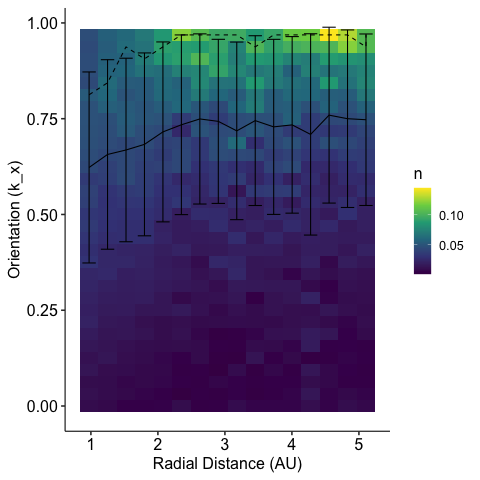

In [47]:
%%R
x_col <- "radial_distance"
y_col <- "k_x"
y_lim <- NULL
x_bins <- 16
y_bins <- 32
xlab <- "Radial Distance (AU)"
ylab <- "Orientation (k_x)"
p <- plot_binned_data(jno_candidates_l1, x_col = x_col, y_col = y_col, x_bins = x_bins, y_bins=y_bins, y_lim = y_lim, log_y = FALSE)
p <- p + labs(x = xlab, y= ylab)
save_plot("orientation_r_dist")
p

In [ ]:
thresold = 0.2

def temp_plot(l1_df, y="j0_norm"):
    return l1_df.pipe(process_events_l2).hvplot(
        x="time", y=y, by="sat", hover_cols=["id_count"], width=300, height=300, legend=False
    )

direction_col = pl.col('k_x').abs()

((
    all_events_l1.pipe(temp_plot, y="j0_norm")
    + all_events_l1.filter(direction_col > thresold).pipe(temp_plot, y="j0_norm")
    + all_events_l1.filter(direction_col < thresold).pipe(temp_plot, y="j0_norm")
) + (
    all_events_l1.pipe(temp_plot, y="L_mn_norm")
    + all_events_l1.filter(direction_col > thresold).pipe(temp_plot, y="L_mn_norm")
    + all_events_l1.filter(direction_col < thresold).pipe(temp_plot, y="L_mn_norm")
)).cols(3)

:Layout
   .NdOverlay.I   :NdOverlay   [sat]
      :Curve   [time]   (j0_norm,id_count)
   .NdOverlay.II  :NdOverlay   [sat]
      :Curve   [time]   (j0_norm,id_count)
   .NdOverlay.III :NdOverlay   [sat]
      :Curve   [time]   (j0_norm,id_count)
   .NdOverlay.IV  :NdOverlay   [sat]
      :Curve   [time]   (L_mn_norm,id_count)
   .NdOverlay.V   :NdOverlay   [sat]
      :Curve   [time]   (L_mn_norm,id_count)
   .NdOverlay.VI  :NdOverlay   [sat]
      :Curve   [time]   (L_mn_norm,id_count)

## Thickness

Note since want different y-axis titles (labels) for each facet, not different facet titles, it is not clear how to do this with `facet_wrap` after `pivot_longer`. Also these are different units, so it is better to plot them separately and combine them together.

### Evolution

In [17]:
%%R

x_var <- "time"
y_vars <- c("L_mn", "L_mn_norm")
xlab <- "Time"
ylabs <- c("Thickness (km)", "Normalized thickness (d_i)")
p <- plot_util(all_events_l2, x_var = x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("thickness_time")

x_var <- "ref_radial_distance"
xlab <- "Referred Radial Distance (AU)"
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("thickness_r")

y_vars <- c("L_mn_n2", "L_mn_norm_n2")
ylabs <- c("Relative thickness", "Normalized relative thickness")
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("thickness_r_N2")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: There were 20 warnings (use warnings() to see them)


Results

![](../figures/thickness_time.png){width=500}
![](../figures/thickness_r.png){width=500}
![](../figures/thickness_r_N2.png){width=500}

### Map

In [24]:
%%R
x_col <- "radial_distance"
y_col <- "L_mn"
y_lim <- NULL
xlab <- "Radial Distance (AU)"
ylab <- "Log Thickness (km)"
p <- plot_binned_data(jno_candidates_l1, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
save_plot("thickness_r_dist")

y_col <- "L_mn_norm"
y_lim <- c(0,100)
ylab <- expression(Log~Normalized~Thickness~(d[i]))
p <- plot_binned_data(jno_candidates_l1, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
save_plot("thickness_N1_r_dist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


Results

![](../figures/thickness_r_dist.png){width=500}
![](../figures/thickness_N1_r_dist.png){width=500}


### Histogram

In [19]:
%%R
x <- "L_mn_norm"
x_lim <- c(0,60)
bins <- 16
facet_var <- "r_bin"
p <- plot_limited_histogram(all_events_l1, x = x, x_lim = x_lim , bins = bins, facet_var=facet_var)
save_plot("thickness_N1_r_hist")

x <- "L_mn_norm_log"
x_lim <- c(0, 2)
facet_var <- "r_bin"
p <- plot_limited_histogram(all_events_l1, x = x, x_lim = x_lim , bins = bins, facet_var=facet_var)
save_plot("thickness_N1_log_r_hist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


Results

![](../figures/thickness_N1_r_hist.png){width=500}
![](../figures/thickness_N1_log_r_hist.png){width=500}


## Current intensity

### Mean value

In [20]:
%%R
x_var <- "time"
y_vars <- c("j0", "j0_norm")
xlab <- "Time"
ylabs <- c("J (nA/m^2)",  "Normalized J (J_A)")
p <- plot_util(all_events_l2, x_var = x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("current_time")

x_var <- "ref_radial_distance"
xlab <- "Referred Radial Distance (AU)"
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("current_r")

y_vars <- c("j0_n2", "j0_norm_n2")
ylabs <- c("Relative J", "Relative normalized J")
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("current_r_N2")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: There were 20 warnings (use warnings() to see them)


Results

![](../figures/current_time.png){width=500}
![](../figures/current_r.png){width=500}
![](../figures/current_r_N2.png){width=500}

### Map

In [21]:
%%R
x_col <- "radial_distance"
y_col <- "j0"
y_lim <- c(0, 15)
xlab <- "Radial Distance (AU)"
ylab <- expression(Log~J~(nA~m^-2))
p <- plot_binned_data(jno_candidates_l1, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
save_plot("current_r_dist")

y_col <- "j0_norm"
y_lim <- c(0, 1)
ylab <- expression(Log~Normalized~J~(J[A]))
p <- plot_binned_data(jno_candidates_l1, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
save_plot("current_N1_r_dist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


Results

![](../figures/current_r_dist.png){width=500}
![](../figures/current_N1_r_dist.png){width=500}


### Histogram

In [22]:
%%R
x <- "j0_norm"
x_lim <- c(0, 1)
facet_var <- "r_bin"
p <- plot_limited_histogram(all_events_l1, x = x, x_lim = x_lim, bins = 8, facet_var=facet_var)
save_plot("current_N1_r_hist")

x <- "j0_norm_log"
x_lim <- c(-2, 0)
p <- plot_limited_histogram(all_events_l1, x = x, x_lim = x_lim, bins = 8, facet_var=facet_var)
save_plot("current_N1_log_r_hist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


Results

![](../figures/current_N1_r_hist.png){width=500}
![](../figures/current_N1_log_r_hist.png){width=500}
